# inisisasi

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import seaborn as sns

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# data

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
input_file = '/content/drive/MyDrive/[CAPSTONE OASEE]/[ML]/[2.6] Model Training/Sentiment Analysis/dataset_sentiment_labeling.csv'

In [5]:
df = pd.read_csv(input_file, encoding='utf-8')

In [6]:
print(df.head())

                                               Title   Timestamp  \
0  NTT Optimistis Persentase Anak Stunting Turun ...  17/05/2023   
1  Kemenperin  Industri Manufaktur Sumbang 70 21 ...  17/05/2023   
2  Tingkatkan Daya Saing Nasional  Industri Hijau...  17/05/2023   
3  Ganjil Genap di Jalur Puncak Berlaku Mulai Har...  17/05/2023   
4      Daftar Lengkap 54 Taman Nasional di Indonesia  17/05/2023   

                                            FullText  \
0  Pencatatan dan Pelaporan Gizi Berbasis Masyara...   
1   Kementerian Perindustrian Kemenperin mengatak...   
2   Menteri Perindustrian Menperin Agus Gumiwang ...   
3   Untuk mencegah terjadinya kemacetan luar bias...   
4  unsur hayati di alam yang terdiri dari sumber ...   

                                                Tags  \
0  NTT stunting SDG02 Tanpa Kelaparan SDG06 Air B...   
1              Ekspor Kemenperin industri manufaktur   
2  industri hijau SDG08 Pekerjaan Layak dan Pertu...   
3  ganjil genap libur nasional

In [7]:
random_df = df.sample(frac=1)  # Mengacak baris DataFrame
print(random_df)

                                                 Title   Timestamp  \
25   Sinergi Ekonomi Kreatif Dorong Pariwisata RI  ...  13/05/2023   
273  AHY Kritik Penegakan Hukum RI Tajam ke Lawan T...  20/05/2023   
248  Hasto soal Partai Merapat Merah Kuning Hijau d...  20/05/2023   
460   Kandungan Dalam Suntikan Vitamin K Berbahaya ...         NaN   
2    Tingkatkan Daya Saing Nasional  Industri Hijau...  17/05/2023   
..                                                 ...         ...   
299  Relawan Gibran dan Jokowi Dukung Prabowo di Pe...  20/05/2023   
80   Hardiknas 2023  Jokowi  Pendidikan Tanggung Ja...  02/05/2023   
590           WARGA PLUMPANG BAKAR RUMAH KEDIAMAN AHOK         NaN   
193  Adriani Peraih Medali Emas Sea Games Kamboja D...  20/05/2023   
28   SMK SMAK Padang Raih Akreditasi Tertinggi Nasi...  12/05/2023   

                                              FullText  \
25    Keberhasilan penyelenggaraan KTT ASEAN di Lab...   
273  Jakarta Ketua Umum Partai Demokrat Agu

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Title                  600 non-null    object
 1   Timestamp              300 non-null    object
 2   FullText               600 non-null    object
 3   Tags                   300 non-null    object
 4   Author                 300 non-null    object
 5   Url                    600 non-null    object
 6   Label                  600 non-null    int64 
 7   SentimentLabel         600 non-null    object
 8   Sentiment_Probability  600 non-null    object
dtypes: int64(1), object(8)
memory usage: 42.3+ KB


# pre

In [9]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [10]:
# Encode sentiment labels
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['SentimentLabel'])

# Split into features and labels
X = df['FullText']
y = df['Label']

In [11]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [12]:
# Text preprocessing
stop_words = set(stopwords.words('indonesian'))
stemmer = PorterStemmer()

In [13]:
def preprocess_text(text):
    # Convert to lowercase
    tokens = text.lower()
    
    # Tokenization
    tokens = nltk.word_tokenize(tokens)
    
    # Filtering
    tokens = [w for w in tokens if not w in stop_words]
    
    # Stemming
    tokens = [stemmer.stem(w) for w in tokens]
    
    return tokens

# Apply preprocessing to train and test data
X_train = X_train.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)

In [14]:
# Initialize tokenizer and BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-uncased')

Some layers from the model checkpoint at bert-base-multilingual-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [15]:
# Tokenization and conversion to input tensors
X_train = X_train.apply(lambda x: tokenizer.encode_plus(' '.join(x), add_special_tokens=True, max_length=512, padding='max_length', truncation=True, return_tensors='tf'))
X_test = X_test.apply(lambda x: tokenizer.encode_plus(' '.join(x), add_special_tokens=True, max_length=512, padding='max_length', truncation=True, return_tensors='tf'))

In [16]:
# Extract BERT embeddings
X_train = X_train.apply(lambda x: bert_model(x['input_ids'])[0])
X_test = X_test.apply(lambda x: bert_model(x['input_ids'])[0])

In [17]:
# Convert tensors to numpy arrays
X_train = np.array([x.numpy() for x in X_train])
X_test = np.array([x.numpy() for x in X_test])

# model

In [18]:
# Define the model architecture
input_shape = X_train.shape[1:]
inputs = Input(shape=input_shape)
x = Conv1D(128, 5, activation='relu')(inputs)
x = GlobalMaxPooling1D()(x[:, -1, :])  # Select the last timestep from the Conv1D output
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(8, activation='relu')(x)
outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 512, 768)]     0         
                                                                 
 conv1d (Conv1D)             (None, 1, 508, 128)       491648    
                                                                 
 tf.__operators__.getitem (S  (None, 508, 128)         0         
 licingOpLambda)                                                 
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_37 (Dropout)        (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256  

# train

In [19]:
# Melakukan reshape pada data train dan test
#X_train = X_train.reshape((-1, 256, 768))
#X_test = X_test.reshape((-1, 256, 768))

# Melatih model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[EarlyStopping(patience=3)])

Epoch 1/20
10/10 [==============================] - 10s 873ms/step - loss: 1.3679 - accuracy: 0.3433 - val_loss: 1.0612 - val_accuracy: 0.4633
Epoch 2/20
10/10 [==============================] - 9s 959ms/step - loss: 1.0734 - accuracy: 0.4067 - val_loss: 1.0501 - val_accuracy: 0.4633
Epoch 3/20
10/10 [==============================] - 9s 915ms/step - loss: 1.0719 - accuracy: 0.4467 - val_loss: 1.0451 - val_accuracy: 0.5167
Epoch 4/20
10/10 [==============================] - 11s 1s/step - loss: 1.0459 - accuracy: 0.4900 - val_loss: 1.0436 - val_accuracy: 0.5267
Epoch 5/20
10/10 [==============================] - 10s 1s/step - loss: 1.0283 - accuracy: 0.5000 - val_loss: 1.0313 - val_accuracy: 0.5300
Epoch 6/20
10/10 [==============================] - 9s 917ms/step - loss: 0.9965 - accuracy: 0.5067 - val_loss: 0.9578 - val_accuracy: 0.5600
Epoch 7/20
10/10 [==============================] - 8s 772ms/step - loss: 0.8689 - accuracy: 0.5833 - val_loss: 0.9255 - val_accuracy: 0.5533
Epoch 8/2

# visualisasi

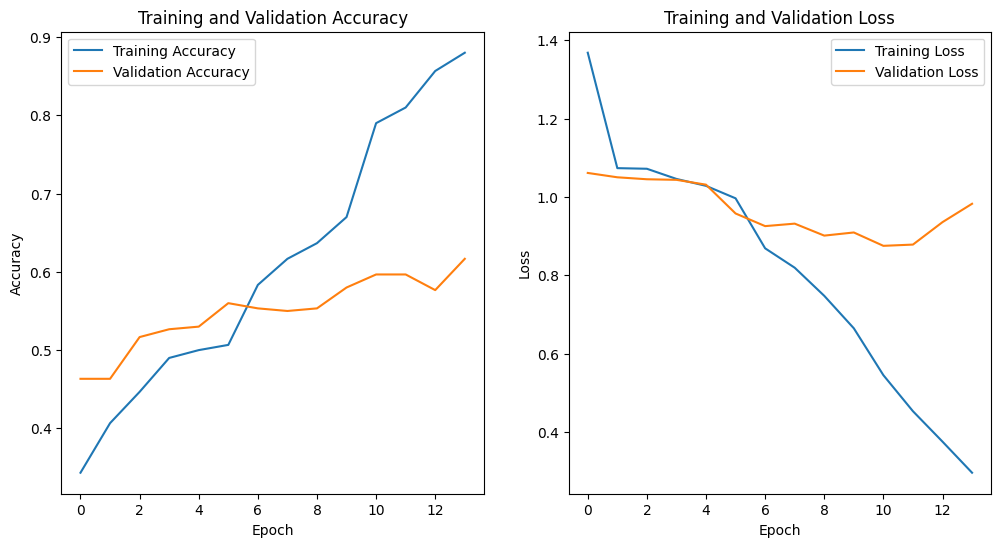

In [20]:
# Visualize training results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [21]:
# Memprediksi probabilitas pada data uji
y_pred_prob = model.predict(X_test)

# Mengambil prediksi kelas dengan probabilitas tertinggi
y_pred = np.argmax(y_pred_prob, axis=1)

10/10 [==============================] - 2s 232ms/step


In [22]:
# Convert sentiment labels back to original format
sentiment_labels = ['negative', 'neutral', 'positive']
y_pred_labels = [sentiment_labels[pred] for pred in y_pred]

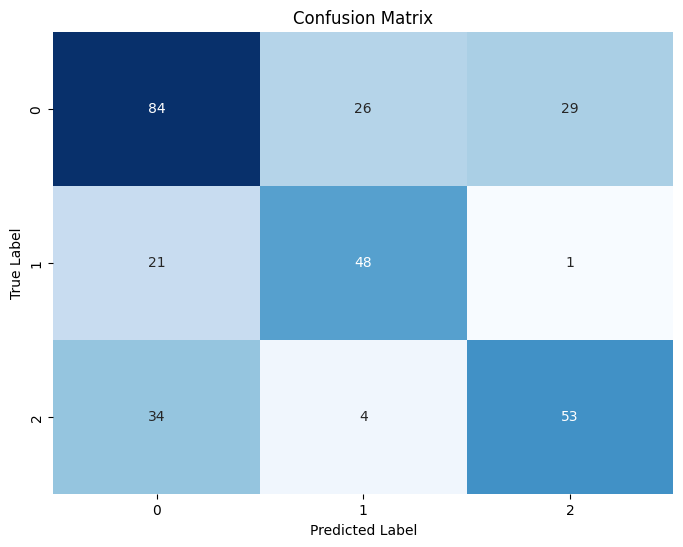

Confusion Matrix:
[[84 26 29]
 [21 48  1]
 [34  4 53]]


In [23]:
# Matriks Confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Menghitung matriks confusion
confusion_mat = cm

# Menampilkan matriks confusion
print("Confusion Matrix:")
print(confusion_mat)

In [24]:
# Menghitung metrik evaluasi
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Menampilkan metrik evaluasi
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.6166666666666667
Precision: 0.6172845227062095
Recall: 0.6166666666666667
F1 Score: 0.6161406233820027


# h5

In [25]:
# Menyimpan model ke dalam file h5
model.save('/content/drive/MyDrive/[CAPSTONE OASEE]/[ML]/[2.6] Model Training/Sentiment Analysis/model_sentiment2.h5')


print("New h5 file saved successfully.")

New h5 file saved successfully.


# test

In [42]:
def preprocess_text(text):
    tokens = text.lower()
    tokens = nltk.word_tokenize(tokens)
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [stemmer.stem(w) for w in tokens]
    return tokens

def get_bert_embeddings(text):
    encoded_text = tokenizer.encode_plus(' '.join(text), add_special_tokens=True, max_length=512, padding='max_length', truncation=True, return_tensors='tf')
    embeddings = bert_model(encoded_text['input_ids'])[0]
    return embeddings.numpy()

def predict_sentiment(embeddings):
    predictions = model.predict(np.expand_dims(embeddings, axis=0))
    sentiment_label = label_encoder.inverse_transform(np.argmax(predictions, axis=1))[0]
    return sentiment_label

In [46]:
input_text = "Your input text here"
preprocessed_text = preprocess_text(input_text)
embeddings = get_bert_embeddings(preprocessed_text)
sentiment_label = predict_sentiment(embeddings)
print("Sentiment Label:", sentiment_label)

1/1 [==============================] - 0s 70ms/step
Sentiment Label: positive
